In [1]:
import pickle
import os
from glob import glob
import datetime
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import cm
import pandas as pd
import numpy as np
import seaborn as sns

plt.style.use(style="ggplot")

# font size in the paper is 9
plt.rcParams.update({"font.size": 9})

# widths of figures in inches
TWO_COLUMN_FIG_WIDTH = 6.25963
# SINGLE_COLUMN_FIG_WIDTH = 3.3374

# Experiment 5

Let's read in the files:

In [2]:
output_dir = "./experiments/experiment5/experiment5_output"
file_pattern = "experiment5_results_*.pickle"

results = []

for file_path in glob(os.path.join(output_dir, file_pattern)):
    with open(file_path, "rb") as f:
        run_results = pickle.load(f)
        results.extend(run_results)

Let's check that we have all the results:

In [3]:
len(results)

14336

These are all the bits of information a single result contains:

In [4]:
list(results[0].keys())

['run_id',
 'duration',
 'run_length',
 'time_until_surpass',
 'exploration_coef',
 'attack_reward',
 'action_dist_0',
 'params',
 'agent_df',
 'lower_tree_query_data',
 'actions',
 'rewards',
 'action_qualities']

Format of the action quality estimate data:

In [5]:
results[0]["action_qualities"]

,time,estimator,actor,qualities,n_expansions
0,0,0,0,"[-0.0019071194080108097, -0.07504321596235283,...","[4826, 112, 14]"
1,0,0,1,"[-0.7734627072000148, -0.20858736828343963, -0...",None
2,0,1,1,"[-0.64249720576, -0.22099006718675532, -0.3730...","[6, 4924, 29]"
3,0,1,0,"[-0.001915490161583056, -0.09030361630316, -0....",None


Let's check the duration of simulations:

In [6]:
subset = [res["duration"] for res in results]
avg_duration = sum((d for d in subset), start=datetime.timedelta(0)) / len(subset)
print(f"Average: {avg_duration}")
print(f"Maximum: {max(subset)}")

Average: 0:02:11.296710
Maximum: 0:05:04.484813


In [7]:
# average time for reasoning level 1 and random action_dist_0
subset = [
    res["duration"]
    for res in results
    if res["params"]["reasoning_level"] == 1 and res["action_dist_0"] == "random"
]
avg_duration = sum((d for d in subset), start=datetime.timedelta(0)) / len(subset)
print(f"Average: {avg_duration}")
print(f"Maximum: {max(subset)}")

Average: 0:03:04.829765
Maximum: 0:05:04.484813


Let's check that we have results from all runs:

In [8]:
run_ids = tuple(res["run_id"] for res in results)
for i in range(896):
    if i not in run_ids:
        print(i)

We've got all runs now!

Let's check the lower-level model query success rate for the strong and weak civilisations:

In [10]:
avg_rates_strong = np.array([0, 0, 0, 0], dtype=np.float_)
avg_rates_weak = np.array([0, 0, 0, 0], dtype=np.float_)
n = 0
for res in results:
    if res["params"]["reasoning_level"] == 0:
        continue

    res_rates_strong = res["lower_tree_query_data"]["Civ 0,"][1:]
    res_rates_weak = res["lower_tree_query_data"]["Civ 1,"][1:]

    assert round(sum(res_rates_strong), 3) == 1
    assert round(sum(res_rates_weak), 3) == 1

    avg_rates_strong += res_rates_strong
    avg_rates_weak += res_rates_weak
    n += 1

avg_rates_strong = avg_rates_strong / n
avg_rates_weak = avg_rates_weak / n
print(f"Weak {avg_rates_weak.round(2)}, strong {avg_rates_strong.round(2)}")

Weak [0.9  0.   0.08 0.02], strong [0.83 0.   0.14 0.03]


Let's create a dataframe of the chosen action in each run:

In [11]:
rows = []

for run_result in results:
    attack_reward = run_result["attack_reward"]
    reasoning_level = run_result["params"]["reasoning_level"]
    exploration_coef = run_result["exploration_coef"]
    action_dist_0 = run_result["action_dist_0"]
    time_until_surpass = run_result["params"]["initial_belief_params"][
        "time_until_surpass"
    ]
    prob_surpass_0 = run_result["params"]["initial_belief_params"]["prob_surpass_0"]
    prob_surpass_1 = run_result["params"]["initial_belief_params"]["prob_surpass_1"]

    run_action_qualities = run_result["action_qualities"]

    for actor in (0, 1):
        # determine the action of the actor
        actor_action_qualities = run_action_qualities[
            (run_action_qualities["estimator"] == actor)
            & (run_action_qualities["actor"] == actor)
        ].iloc[0]["qualities"]

        # find the action with the highest quality
        best_action = [
            q_i
            for q_i, q in enumerate(actor_action_qualities)
            if q == max(actor_action_qualities)
        ]
        assert len(best_action) == 1
        best_action = best_action[0]

        # add row
        rows.append(
            (
                attack_reward,
                reasoning_level,
                time_until_surpass,
                prob_surpass_0,
                prob_surpass_1,
                actor,
                exploration_coef,
                action_dist_0,
                best_action,
            )
        )

action_data = pd.DataFrame(
    rows,
    columns=(
        "attack_reward",
        "reasoning_level",
        "time_until_surpass",
        "prob_surpass_0",
        "prob_surpass_1",
        "actor",
        "exploration_coef",
        "action_dist_0",
        "action",
    ),
)

In [12]:
action_data

,attack_reward,reasoning_level,time_until_surpass,prob_surpass_0,prob_surpass_1,actor,exploration_coef,action_dist_0,action
0,0.0,1,2,0.320147,0.405529,0,0.3,random,0
1,0.0,1,2,0.320147,0.405529,1,0.3,random,1
2,0.0,1,2,0.320147,0.405529,0,0.3,passive,0
3,0.0,1,2,0.320147,0.405529,1,0.3,passive,0
4,-0.1,1,2,0.320147,0.405529,0,0.3,random,2
...,...,...,...,...,...,...,...,...,...
28667,0.0,1,4,0.072726,0.080237,1,0.5,passive,0
28668,-0.1,1,4,0.072726,0.080237,0,0.5,random,2
28669,-0.1,1,4,0.072726,0.080237,1,0.5,random,2
28670,-0.1,1,4,0.072726,0.080237,0,0.5,passive,2


Let's first visualise the experiment in reasoning level 0 ('experiment 5a').

In [13]:
data_5A = action_data[
    (action_data["reasoning_level"] == 0)
    & (action_data["action_dist_0"] == "random")
    & (action_data["exploration_coef"] == 0.5)
].copy()

# create bins for prob_surpass_0
prob_bins = np.linspace(0, 1, 21)
data_5A["prob_surpass_0_bin"] = pd.cut(x=data_5A["prob_surpass_0"], bins=prob_bins)

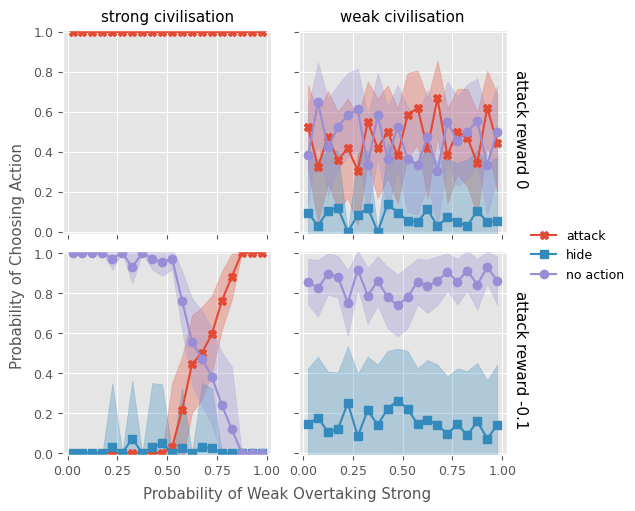

In [14]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(TWO_COLUMN_FIG_WIDTH, 5),
    constrained_layout=True,
    sharey=True,
    sharex=True,
)

action_names = {0: "attack", 1: "hide", 2: "no action"}
action_symbols = {0: "X", 1: "s", 2: "o"}
agent_names = {0: "strong civilisation", 1: "weak civilisation"}


for plot_column, actor in enumerate((0, 1)):
    for plot_row, attack_reward in enumerate((0, -0.1)):
        # plot on the desired axes
        ax = axs[plot_row, plot_column]

        # find correct subset of data
        subset = data_5A[
            (data_5A["actor"] == actor) & (data_5A["attack_reward"] == attack_reward)
        ]

        # calculate proportions within each bin
        action_proportions = subset.groupby("prob_surpass_0_bin")[
            "action"
        ].value_counts(normalize=True)
        action_counts = subset.groupby("prob_surpass_0_bin")["action"].value_counts()
        proportion_error_margins = 1.96 * np.sqrt(
            action_proportions * (1 - action_proportions) / action_counts
        )
        action_proportions = action_proportions.unstack(level=1, fill_value=0)
        proportion_error_margins = proportion_error_margins.unstack(
            level=1, fill_value=0
        )
        action_proportions.index = pd.IntervalIndex(
            action_proportions.index, name="attack_reward_bin_mid"
        ).mid
        proportion_error_margins.index = pd.IntervalIndex(
            proportion_error_margins.index, name="attack_reward_bin_mid"
        ).mid

        # plot
        for action in action_proportions.columns:
            proportions = action_proportions[action]
            error_margin = proportion_error_margins[action]
            ax.plot(
                proportions.index,
                proportions,
                label=action_names[action],
                color=f"C{action}",
                marker=action_symbols[action],
            )
            ax.fill_between(
                proportions.index,
                proportions + error_margin,
                proportions - error_margin,
                alpha=0.3,
                color=f"C{action}",
            )

        if plot_row == 0:
            ax.set_title(agent_names[actor], fontsize="large")
        ax.set_ylim(-0.01, 1.01)


fig.supxlabel(
    "Probability of Weak Overtaking Strong", color=plt.rcParams["xtick.color"], x=0.45
)
fig.supylabel("Probability of Choosing Action", color=plt.rcParams["xtick.color"])

legend_handles = [
    mlines.Line2D(
        [],
        [],
        color=f"C{action}",
        marker=action_symbols[action],
        label=action_names[action],
    )
    for action in (0, 1, 2)
]

fig.legend(handles=legend_handles, loc="outside right", frameon=False)

fig.text(x=0.81, y=0.64, s="attack reward 0", rotation=-90, fontsize="large")
fig.text(x=0.81, y=0.16, s="attack reward -0.1", rotation=-90, fontsize="large")

# plt.savefig('paper/experiment5a.pdf')
plt.show()

Next, let's investigate the level 1 situation (experiment 5B):

In [15]:
data_5B = action_data[
    (action_data["reasoning_level"] == 1)
    & (action_data["action_dist_0"] == "random")
    & (action_data["exploration_coef"] == 0.3)
].copy()

# create bins for prob_surpass_0 and prob_surpass_1
prob_bins = np.linspace(0, 1, 6)
data_5B["prob_surpass_0_bin"] = pd.cut(x=data_5B["prob_surpass_0"], bins=prob_bins)
data_5B["prob_surpass_1_bin"] = pd.cut(x=data_5B["prob_surpass_1"], bins=prob_bins)

data_5B

,attack_reward,reasoning_level,time_until_surpass,prob_surpass_0,prob_surpass_1,actor,exploration_coef,action_dist_0,action,prob_surpass_0_bin,prob_surpass_1_bin
0,0.0,1,2,0.320147,0.405529,0,0.3,random,0,"(0.2, 0.4]","(0.4, 0.6]"
1,0.0,1,2,0.320147,0.405529,1,0.3,random,1,"(0.2, 0.4]","(0.4, 0.6]"
4,-0.1,1,2,0.320147,0.405529,0,0.3,random,2,"(0.2, 0.4]","(0.4, 0.6]"
5,-0.1,1,2,0.320147,0.405529,1,0.3,random,2,"(0.2, 0.4]","(0.4, 0.6]"
16,0.0,1,4,0.320147,0.405529,0,0.3,random,0,"(0.2, 0.4]","(0.4, 0.6]"
...,...,...,...,...,...,...,...,...,...,...,...
28645,-0.1,1,2,0.072726,0.080237,1,0.3,random,2,"(0.0, 0.2]","(0.0, 0.2]"
28656,0.0,1,4,0.072726,0.080237,0,0.3,random,0,"(0.0, 0.2]","(0.0, 0.2]"
28657,0.0,1,4,0.072726,0.080237,1,0.3,random,2,"(0.0, 0.2]","(0.0, 0.2]"
28660,-0.1,1,4,0.072726,0.080237,0,0.3,random,2,"(0.0, 0.2]","(0.0, 0.2]"


('strong civilisation (attack)', 0)
prob_surpass_1_bin  0.1  0.3  0.5  0.7  0.9
prob_surpass_0_bin                         
0.9                 0.0  0.0  0.0  0.0  0.0
0.7                 0.0  0.0  0.0  0.0  0.0
0.5                 0.0  0.0  0.0  0.0  0.0
0.3                 0.0  0.0  0.0  0.0  0.0
0.1                 0.0  0.0  0.0  0.0  0.0
('strong civilisation (attack)', -0.1)
prob_surpass_1_bin  0.1  0.3  0.5  0.7  0.9
prob_surpass_0_bin                         
0.9                 NaN  NaN  NaN  NaN  NaN
0.7                 NaN  NaN  NaN  NaN  NaN
0.5                 NaN  NaN  NaN  NaN  NaN
0.3                 NaN  NaN  NaN  NaN  NaN
0.1                 NaN  NaN  NaN  NaN  NaN
('weak civilisation (hide)', 0)
prob_surpass_1_bin       0.1       0.3       0.5       0.7       0.9
prob_surpass_0_bin                                                  
0.9                 0.199764  0.199852  0.247364  0.227138  0.268012
0.7                 0.172524  0.126342  0.147741  0.217778  0.154776
0

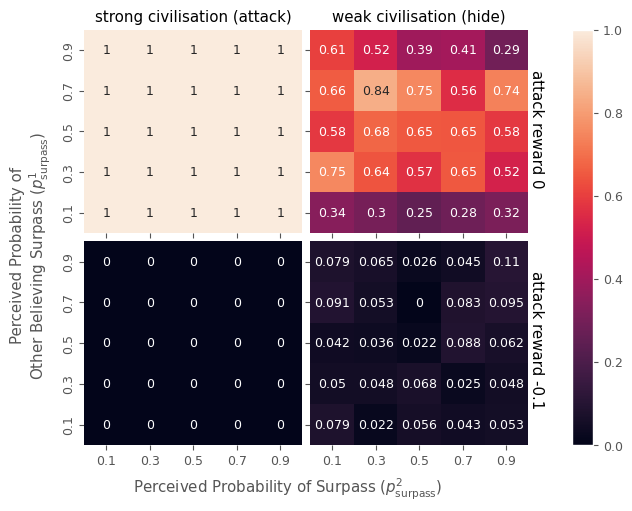

In [16]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(TWO_COLUMN_FIG_WIDTH, 5),
    constrained_layout=True,
    sharex=True,
    sharey=True,
)

action_names = {0: "attack", 1: "hide", 2: "no action"}
agent_names = {0: "strong civilisation (attack)", 1: "weak civilisation (hide)"}

actor_display_action = {0: 0, 1: 1}

for plot_column, actor in enumerate((0, 1)):
    for plot_row, attack_reward in enumerate((0, -0.1)):
        action = actor_display_action[actor]

        # plot on the desired axes
        ax = axs[plot_row, plot_column]

        # find correct subset of data
        subset = data_5B[
            (data_5B["actor"] == actor) & (data_5B["attack_reward"] == attack_reward)
        ]

        # calculate proportions within each bin
        action_proportions = subset.groupby(
            ["prob_surpass_0_bin", "prob_surpass_1_bin"]
        )["action"].value_counts(normalize=True)
        action_proportions = action_proportions.unstack(level=2, fill_value=0)
        action_proportions = action_proportions.reset_index()
        action_proportions["prob_surpass_0_bin"] = np.round(
            pd.IntervalIndex(action_proportions["prob_surpass_0_bin"]).mid, 3
        )
        action_proportions["prob_surpass_1_bin"] = np.round(
            pd.IntervalIndex(action_proportions["prob_surpass_1_bin"]).mid, 3
        )

        action_counts = subset.groupby(["prob_surpass_0_bin", "prob_surpass_1_bin"])[
            "action"
        ].value_counts()
        action_counts = action_counts.unstack(level=2, fill_value=0)
        action_counts = action_counts.reset_index()
        action_counts["prob_surpass_0_bin"] = np.round(
            pd.IntervalIndex(action_counts["prob_surpass_0_bin"]).mid, 3
        )
        action_counts["prob_surpass_1_bin"] = np.round(
            pd.IntervalIndex(action_counts["prob_surpass_1_bin"]).mid, 3
        )

        # make sure all actions are present
        if action not in action_proportions.columns:
            action_proportions[action] = 0

        if action not in action_counts.columns:
            action_counts[action] = 0

        # turn into rectangular fomrat
        action_proportions = action_proportions.pivot(
            index="prob_surpass_0_bin", columns="prob_surpass_1_bin", values=action
        )

        action_counts = action_counts.pivot(
            index="prob_surpass_0_bin", columns="prob_surpass_1_bin", values=action
        )

        # reverse rows
        action_proportions = action_proportions.iloc[::-1]
        action_counts = action_counts.iloc[::-1]

        # calculate error margin
        proportion_error_margins = 1.96 * np.sqrt(
            action_proportions * (1 - action_proportions) / action_counts
        )
        print((agent_names[actor], attack_reward))
        print(proportion_error_margins)

        # plot heat map
        map = sns.heatmap(
            action_proportions, ax=ax, vmin=0, vmax=1, annot=True, cbar=False
        )

        if plot_row == 0:
            ax.set_title(agent_names[actor], fontsize="large")

        ax.set_xlabel("")
        ax.set_ylabel("")

fig.supxlabel(
    r"Perceived Probability of Surpass ($p_{\mathrm{surpass}}^2$)",
    color=plt.rcParams["xtick.color"],
    x=0.45,
)
fig.supylabel(
    r"Perceived Probability of"
    + "\n"
    + "Other Believing Surpass ($p_{\mathrm{surpass}}^1$)",
    color=plt.rcParams["xtick.color"],
    ma="center",
)
fig.text(x=0.835, y=0.64, s="attack reward 0", rotation=-90, fontsize="large")
fig.text(x=0.835, y=0.2, s="attack reward -0.1", rotation=-90, fontsize="large")

fig.colorbar(
    cm.ScalarMappable(cmap=sns.color_palette("rocket", as_cmap=True)),
    ax=axs,
    location="right",
    pad=0.1,
)
# plt.savefig("paper/experiment5b.pdf")
plt.show()